In [1]:
import os
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../sampler-comparison')
sys.path.append('../../../sampler-evaluation')
sys.path.append('../../../')
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sampler_evaluation
from sampler_comparison.samplers import samplers
import seaborn as sns

batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
# import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns

2025-07-11 14:06:07.223685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752267967.239872 1409728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752267967.244843 1409728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 14:06:07.264449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

In [4]:
from functools import partial
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc

model=banana()

sampler = partial(adjusted_hmc,num_tuning_steps=1000, integrator_type='velocity_verlet', L_proposal_factor=1.25,target_acc_rate=0.9, alba_factor=0.23, random_trajectory_length=False, diagonal_preconditioning=True)

samples, metadata = sampler(return_samples=True)(
        model=gym.targets.Banana(), 
        num_steps=10000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(2,)), 
        key=jax.random.key(0))


unadjusted L before alba: (Array(1., dtype=float32, weak_type=True), Array(0.07427059, dtype=float32, weak_type=True))
unadjusted params: (Array(0.7799794, dtype=float32), Array(0.07427059, dtype=float32, weak_type=True))
adjusted params: (Array(0.7799794, dtype=float32), Array(0.13055949, dtype=float32, weak_type=True))


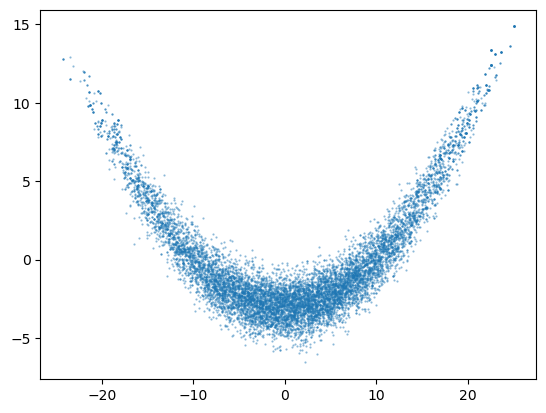

In [5]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

## Running multiple chains

Often we want to run multiple chains in parallel. In Jax, this can be done as follows:

In [6]:
batch_size = 128

init_keys = jax.random.split(jax.random.key(3), batch_size)

keys = jax.random.split(jax.random.key(3), batch_size)

initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)

num_steps = 20000

samples, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=True)(
        model=model, num_steps=num_steps, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

## Analysing the efficiency of the sampler

To analyse the efficiency of the sampler, we can calculate the *standardized squared error* of $x^2$ and $x$,  respectively defined as:

$\frac{(E_{\mathit{sampler}}[x^2]-E[x^2])^2}{Var[x^2]}$ and $\frac{(E_{\mathit{sampler}}[x]-E[x])^2}{Var[x]}$, where $E_{\mathit{sampler}}$ is the empirical estimate of the expectation. We can then count how many steps of the kernel (and in particular for gradient based samplers, how many gradient calls), it takes for these statistics to drop below a threshold (by default $0.01$). In code:

In [5]:
samples.shape

(128, 20000, 2)

In [7]:

error_at_each_step = jnp.nanmedian(get_standardized_squared_error(
    samples, 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2
    ),axis=0)

gradient_calls_per_proposal = metadata['num_grads_per_proposal'].mean()

samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal

print("Gradient calls to low error", samples_to_low_err)

final error is 0.006967142689973116
Gradient calls to low error 107792.96


## Effective sample size (ESS)

We can also calculate ESS, either by the reciprocal of the number of gradient calls to low error, or via an estimate of the autocorrelation time. In code:

In [8]:
from blackjax.diagnostics import effective_sample_size


ess_correlation = jnp.min(effective_sample_size(samples)) / (num_steps * gradient_calls_per_proposal)
ess_bias = 100 / samples_to_low_err

print("Ess by bias:", ess_bias)
print("Ess by correlation:", ess_correlation)

Ess by bias: 0.0009277044
Ess by correlation: 0.047046237


## Streaming averages, for large models

For models with many parameters (that is, high dimensional distributions), the array of samples, of shape `[batch_size, num_samples, num_dimensions]`, can be too large to fit in memory. However, all we need to keep at each step is a streaming average of the expectations $\mathbb{E}[x]$ and $\mathbb{E}[x^2]$, and return an array of the standarized squared errors at each step, of shape `[num_samples]`.

This is done as follows:

In [11]:
squared_errors, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=False)(
        model=model, num_steps=20000, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

err_t_max_x2 = jnp.median(squared_errors['square']['max'], axis=0)
samples_to_low_max_x2 = samples_to_low_error(
err_t_max_x2)* metadata["num_grads_per_proposal"].mean()

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/goog

final error is 0.006967106368392706


## Inspecting benchmark results

This repository provides precalculated results of measuring the efficiency of a range of samplers on a range of models. These results can be viewed as follows:

In [18]:
import itertools
import os
import pandas as pd
from sampler_comparison.samplers import samplers
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.german_credit import german_credit
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from sampler_evaluation.models.item_response import item_response
from sampler_evaluation.models.rosenbrock import Rosenbrock
from sampler_evaluation.models.neals_funnel import neals_funnel
from sampler_evaluation.models.banana_mams_paper import banana_mams_paper
from sampler_comparison.samplers import samplers

models = [
    # banana(),
    brownian_motion(),
    german_credit(),
    Rosenbrock(),
    # stochastic_volatility_mams_paper,
    item_response(),
]

models = {
    # "Banana": banana(),
    # "Brownian_Motion": brownian_motion(),
    # "German_Credit": german_credit(),
    # "Rosenbrock": Rosenbrock(),
    # # "Neals_Funnel": neals_funnel(),
    # "Stochastic_Volatility": stochastic_volatility(),
    # "Item_Response": item_response(),

    model.name: model

    for model in models
}


# models = {
#     # "Banana_MAMS_Paper": banana_mams_paper,
#     banana().name: banana(),
#     # "Gaussian_MAMS_Paper": IllConditionedGaussian(ndims=100, condition_number=100, eigenvalues='log'),
#     brownian_motion().name: brownian_motion(),
#     # "German_Credit": german_credit(),
#     # "Rosenbrock": Rosenbrock(),
#     # "Neals_Funnel_MAMS_Paper": neals_funnel(),
#     # "Stochastic_Volatility_MAMS_Paper": stochastic_volatility_mams_paper,
#     # "Item_Response": item_response(),
# }

# samplers = {"nuts", "adjusted_microcanonical", ""}

df = pd.concat([pd.read_csv(os.path.join('../..',f'results/{model}', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    new_df = df[(df['max']==True) & (df['statistic']=='square')]
    # display numbers without scientific notation
    # new_df = new_df[df['Model']=='banana']
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(new_df)

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,ess_corr,max,statistic,num_tuning_grads,L,step_size
2,2,adjusted_hmc,vector_brownian_motion_unknown_scales_missing_...,17379.49,NaN,True,square,193968.50,2.00,0.18
6,2,adjusted_hmc,vector_german_credit_numeric_sparse_logistic_r...,56453.92,NaN,True,square,637300.35,1.97,0.05
10,2,adjusted_hmc,rosenbrock_36d,95042.79,NaN,True,square,902614.69,2.00,0.04
14,2,adjusted_hmc,vector_synthetic_item_response_theory,44356.63,NaN,True,square,265941.53,1.41,0.13
18,2,nuts,vector_brownian_motion_unknown_scales_missing_...,31052.17,NaN,True,square,103634.47,4.41,0.19
22,2,nuts,vector_german_credit_numeric_sparse_logistic_r...,74809.59,NaN,True,square,344178.78,3.97,0.06
26,2,nuts,rosenbrock_36d,160974.99,NaN,True,square,519500.80,5.35,0.04
30,2,nuts,vector_synthetic_item_response_theory,75578.00,NaN,True,square,151195.48,3.70,0.12
34,2,adjusted_microcanonical,vector_brownian_motion_unknown_scales_missing_...,13638.99,NaN,True,square,187271.85,11.31,1.09
38,2,adjusted_microcanonical,vector_german_credit_numeric_sparse_logistic_r...,55341.56,NaN,True,square,634560.26,14.11,0.38


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

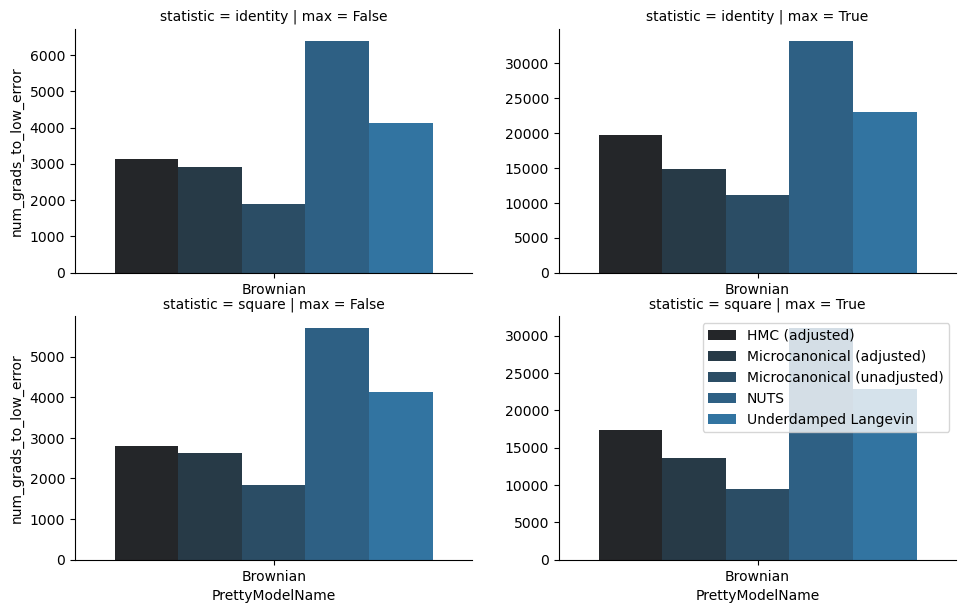

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

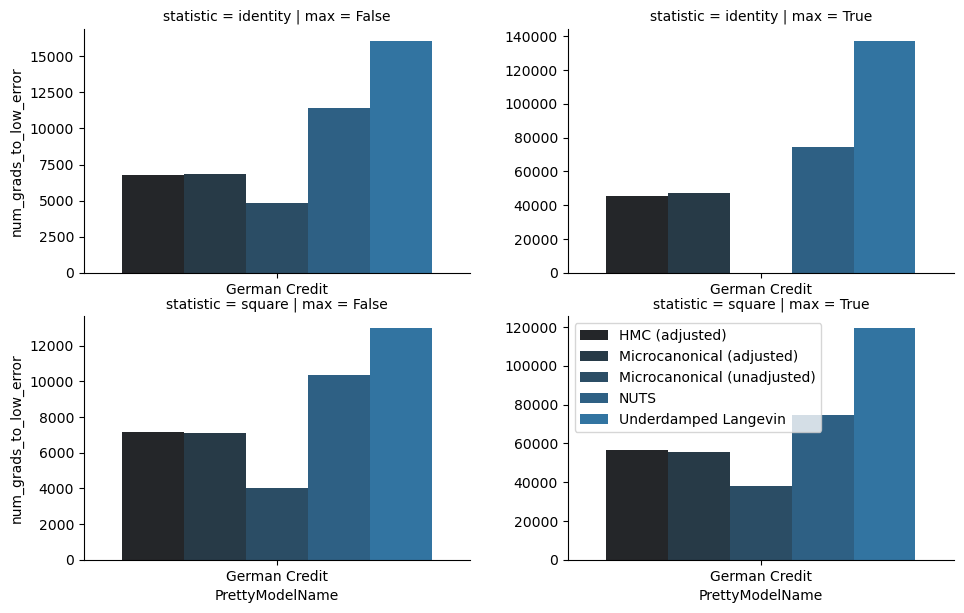

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

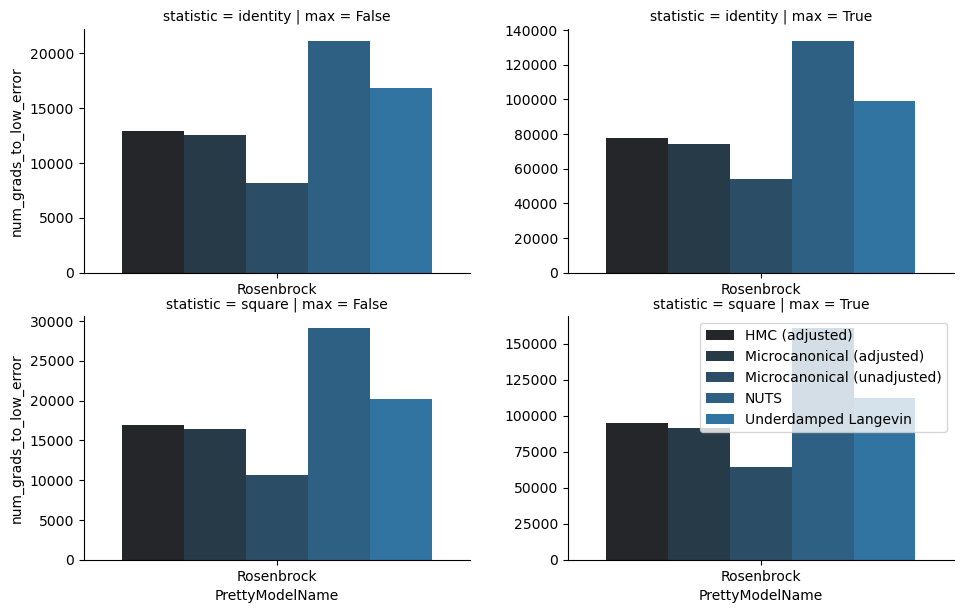

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

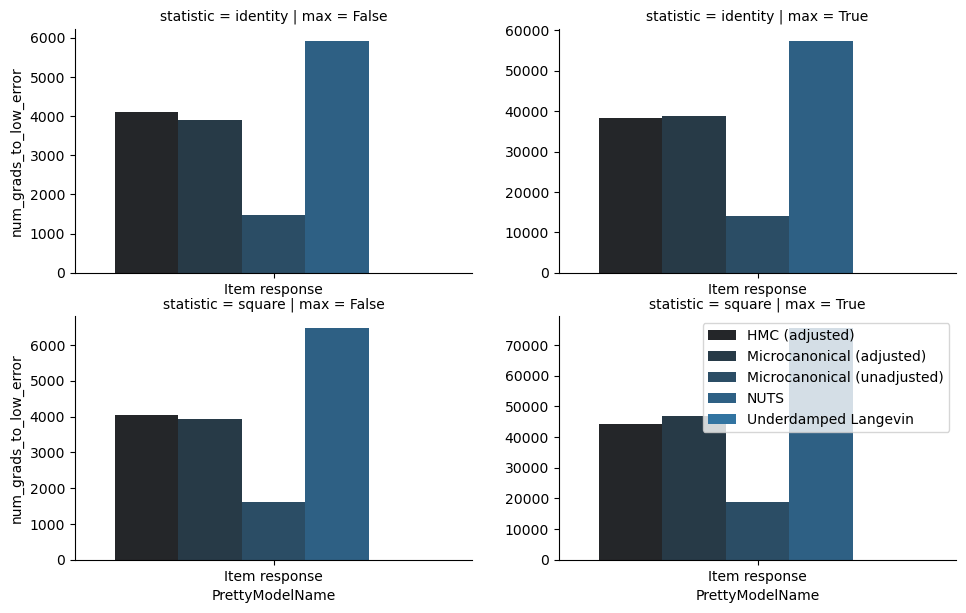

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sampler_evaluation

def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({
    "nuts": "NUTS", 
    "unadjusted_microcanonical": "Microcanonical (unadjusted)",
    "adjusted_microcanonical": "Microcanonical (adjusted)",
    "underdamped_langevin" : "Underdamped Langevin",
    "adjusted_microcanonical_langevin" : "MAMS Langevin (adjusted)",
    "adjusted_hmc" : "HMC (adjusted)",
    }.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df["PrettyModelName"] = df["Model"].apply({
    banana().name: "Banana",
    brownian_motion().name: "Brownian",
    german_credit().name: "German Credit",
    Rosenbrock().name: "Rosenbrock",
    stochastic_volatility_mams_paper.name: "Stochastic volatility",
    sampler_evaluation.models.item_response().name: "Item response",
    }.get)
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'PrettyModelName',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["PrettyModelName"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  plt.gcf().set_size_inches(10, 6)
  plt.show()

for model in models:
  display_results(model, df, include_tuning=False)

In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,max,statistic,num_tuning_grads,L,step_size
0,0,adjusted_microcanonical,Banana_MAMS_Paper,1.407867e+04,True,x2,1.529316e+05,2.828427,0.177159
1,1,adjusted_microcanonical,Banana_MAMS_Paper,8.247459e+03,False,x2,1.529316e+05,2.828427,0.177159
2,2,adjusted_microcanonical,Banana_MAMS_Paper,inf,True,x,1.529316e+05,2.828427,0.177159
3,3,adjusted_microcanonical,Banana_MAMS_Paper,inf,False,x,1.529316e+05,2.828427,0.177159
4,0,adjusted_microcanonical,Gaussian_MAMS_Paper,3.249524e+03,True,x2,7.299984e+04,10.291699,5.596306
5,1,adjusted_microcanonical,Gaussian_MAMS_Paper,4.342512e+02,False,x2,7.299984e+04,10.291699,5.596306
6,2,adjusted_microcanonical,Gaussian_MAMS_Paper,4.414274e+03,True,x,7.299984e+04,10.291699,5.596306
7,3,adjusted_microcanonical,Gaussian_MAMS_Paper,5.704147e+02,False,x,7.299984e+04,10.291699,5.596306
8,0,adjusted_microcanonical,Brownian_Motion,1.352831e+04,True,x2,1.862522e+05,11.313708,1.086937
9,1,adjusted_microcanonical,Brownian_Motion,2.797522e+03,False,x2,1.862522e+05,11.313708,1.086937


In [33]:
# from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)

batch_size = 512
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
num_cores = jax.local_device_count()

# print(os.listdir("../../../sampler-comparison"))

# import sys
sys.path.append("../../../sampler-comparison")
sys.path.append("../../../sampler-evaluation")
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
# raise Exception("stop")

from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
)
from functools import partial
# import sys
sys.path.append("../sampler-comparison")
sys.path.append("../sampler-evaluation")
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
import pandas as pd
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
import os
from results.run_benchmarks import run_benchmarks
# import sampler_evaluation
from sampler_evaluation.models.dirichlet import Dirichlet
import jax
from results.run_benchmarks import lookup_results
import itertools
import jax.numpy as jnp
from sampler_evaluation.models.german_credit import german_credit

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

NameError: name 'full_results' is not defined

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,grads_to_low_error_std,ess_corr,max,statistic,num_tuning_grads,L,step_size,batch_size,mh,canonical,langevin,tuning,integrator_type,precond
5,5,adjusted_canonical_langevin_alba_velocity verl...,ICG_2_1,165.292682,6.424920,NaN,False,square,17714.255859,1.001144,0.888089,NaN,adjusted,canonical,langevin,alba,velocity verlet,precond:True
57,5,adjusted_canonical_langevin_alba_mclachlan_pre...,ICG_2_1,261.800000,10.608954,NaN,False,square,34954.855469,1.079756,0.981596,NaN,adjusted,canonical,langevin,alba,mclachlan,precond:True
109,5,adjusted_canonical_nolangevin_alba_velocity ve...,ICG_2_1,150.700000,88.277333,NaN,False,square,17564.000000,0.934003,0.849094,NaN,adjusted,canonical,nolangevin,alba,velocity verlet,precond:True
161,5,adjusted_canonical_nolangevin_alba_mclachlan_p...,ICG_2_1,310.200000,5.494870,NaN,False,square,34954.546875,1.022425,0.929477,NaN,adjusted,canonical,nolangevin,alba,mclachlan,precond:True
213,5,adjusted_microcanonical_langevin_alba_velocity...,ICG_2_1,224.400000,10.348507,NaN,False,square,21876.689453,1.121598,1.019635,NaN,adjusted,microcanonical,langevin,alba,velocity verlet,precond:True
265,5,adjusted_microcanonical_langevin_alba_mclachla...,ICG_2_1,398.200000,9.186381,NaN,False,square,43752.187500,1.263781,1.148892,NaN,adjusted,microcanonical,langevin,alba,mclachlan,precond:True
317,5,adjusted_microcanonical_nolangevin_alba_veloci...,ICG_2_1,141.900000,9.277602,NaN,False,square,21878.167969,1.453265,1.321150,512.0,adjusted,microcanonical,nolangevin,alba,velocity verlet,precond:True
369,5,adjusted_microcanonical_nolangevin_alba_mclach...,ICG_2_1,292.600000,7.697604,NaN,False,square,43753.949219,1.637809,1.488918,NaN,adjusted,microcanonical,nolangevin,alba,mclachlan,precond:True
421,5,unadjusted_canonical_langevin_alba_velocity ve...,ICG_2_1,363.000000,23.948436,NaN,False,square,5556.000000,0.977943,0.401481,NaN,unadjusted,canonical,langevin,alba,velocity verlet,precond:True
473,5,unadjusted_canonical_langevin_alba_mclachlan_p...,ICG_2_1,156.000000,7.786983,NaN,False,square,11112.000000,0.759668,1.337102,NaN,unadjusted,canonical,langevin,alba,mclachlan,precond:True


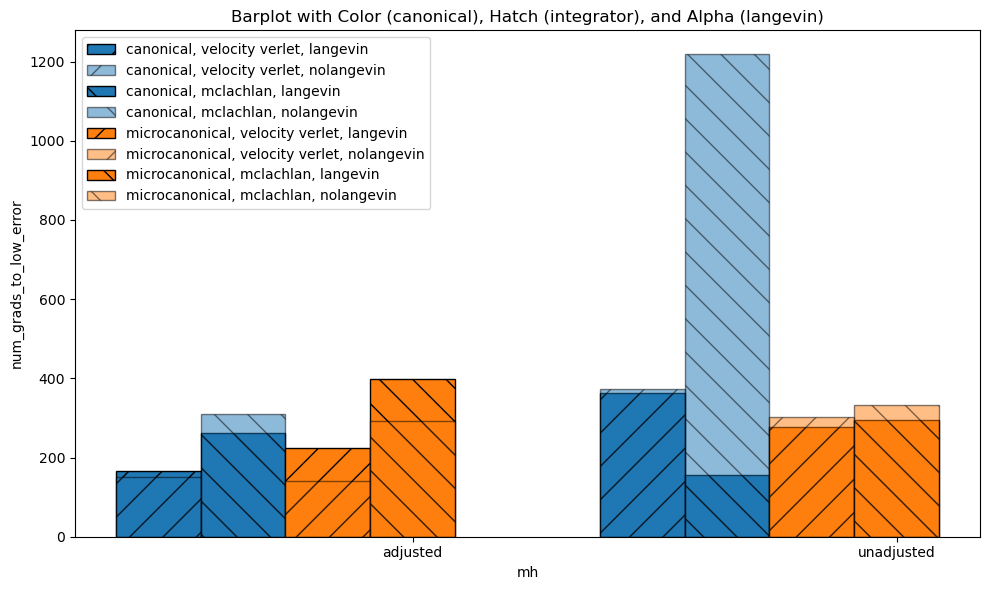

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,grads_to_low_error_std,ess_corr,max,statistic,num_tuning_grads,L,step_size,batch_size,mh,canonical,langevin,tuning,integrator_type,precond
9,3,adjusted_canonical_langevin_alba_velocity verl...,ICG_100_1,797.026626,3.284570,NaN,False,square,75435.875000,1.281780,0.345879,128.0,adjusted,canonical,langevin,alba,velocity verlet,precond:True
61,3,adjusted_canonical_langevin_alba_mclachlan_pre...,ICG_100_1,413.600000,3.122355,NaN,False,square,112306.046875,1.025895,0.932632,128.0,adjusted,canonical,langevin,alba,mclachlan,precond:True
113,3,adjusted_canonical_nolangevin_alba_velocity ve...,ICG_100_1,719.053660,4.592385,NaN,False,square,73939.851562,0.990706,0.354308,128.0,adjusted,canonical,nolangevin,alba,velocity verlet,precond:True
165,3,adjusted_canonical_nolangevin_alba_mclachlan_p...,ICG_100_1,468.600000,3.096773,NaN,False,square,112305.953125,0.968300,0.880273,128.0,adjusted,canonical,nolangevin,alba,mclachlan,precond:True
217,3,adjusted_microcanonical_langevin_alba_velocity...,ICG_100_1,663.714750,4.174434,NaN,False,square,78056.625000,9.953115,4.980856,128.0,adjusted,microcanonical,langevin,alba,velocity verlet,precond:True
269,3,adjusted_microcanonical_langevin_alba_mclachla...,ICG_100_1,675.400000,5.060543,NaN,False,square,129910.765625,9.721963,8.838148,128.0,adjusted,microcanonical,langevin,alba,mclachlan,precond:True
321,3,adjusted_microcanonical_nolangevin_alba_veloci...,ICG_100_1,635.473432,3.892300,NaN,False,square,79168.601562,12.191517,4.892638,128.0,adjusted,microcanonical,nolangevin,alba,velocity verlet,precond:True
373,3,adjusted_microcanonical_nolangevin_alba_mclach...,ICG_100_1,488.400003,5.368650,NaN,False,square,129911.734375,12.472567,11.338697,128.0,adjusted,microcanonical,nolangevin,alba,mclachlan,precond:True
425,3,unadjusted_canonical_langevin_alba_velocity ve...,ICG_100_1,565.000000,7.480715,NaN,False,square,35556.000000,0.972904,0.396536,128.0,unadjusted,canonical,langevin,alba,velocity verlet,precond:True
477,3,unadjusted_canonical_langevin_alba_mclachlan_p...,ICG_100_1,222.000000,1.859462,NaN,False,square,71112.000000,0.765744,1.330346,128.0,unadjusted,canonical,langevin,alba,mclachlan,precond:True


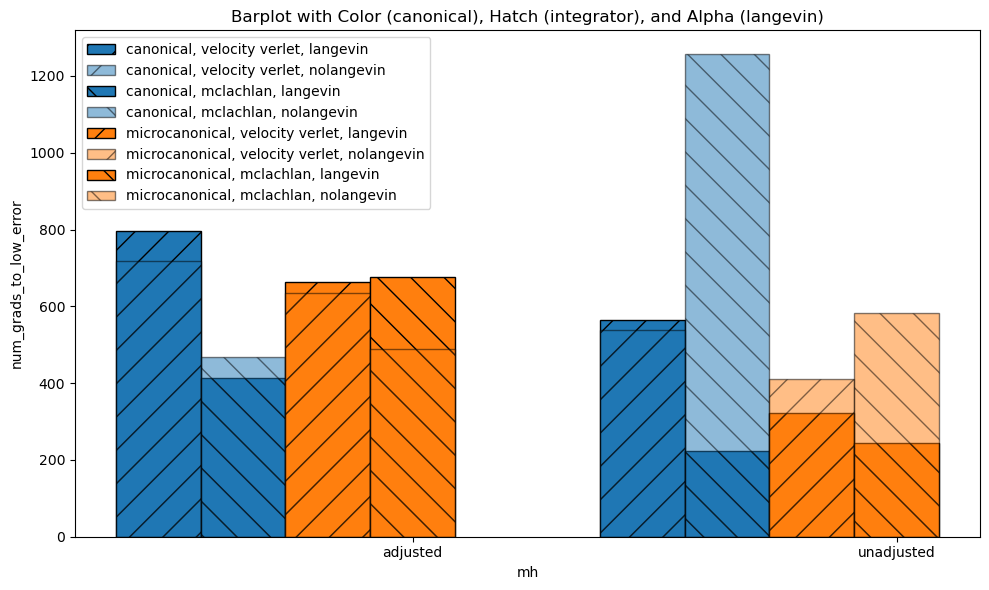

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,grads_to_low_error_std,ess_corr,max,statistic,num_tuning_grads,L,step_size,batch_size,mh,canonical,langevin,tuning,integrator_type,precond
13,3,adjusted_canonical_langevin_alba_velocity verl...,vector_brownian_motion_unknown_scales_missing_...,4375.206215,29.763259,NaN,False,square,178969.109375,2.000000,0.159984,128.0,adjusted,canonical,langevin,alba,velocity verlet,precond:True
65,3,adjusted_canonical_langevin_alba_mclachlan_pre...,vector_brownian_motion_unknown_scales_missing_...,3879.973831,23.638181,NaN,False,square,275477.593750,2.000000,0.350552,128.0,adjusted,canonical,langevin,alba,mclachlan,precond:True
117,3,adjusted_canonical_nolangevin_alba_velocity ve...,vector_brownian_motion_unknown_scales_missing_...,3116.133908,21.064890,NaN,False,square,172369.656250,1.996295,0.181051,128.0,adjusted,canonical,nolangevin,alba,velocity verlet,precond:True
169,3,adjusted_canonical_nolangevin_alba_mclachlan_p...,vector_brownian_motion_unknown_scales_missing_...,2983.079551,22.550308,NaN,False,square,276395.875000,2.000000,0.345412,128.0,adjusted,canonical,nolangevin,alba,mclachlan,precond:True
221,3,adjusted_microcanonical_langevin_alba_velocity...,vector_brownian_motion_unknown_scales_missing_...,3450.938487,41.160830,NaN,False,square,181933.328125,11.305279,1.264487,128.0,adjusted,microcanonical,langevin,alba,velocity verlet,precond:True
273,3,adjusted_microcanonical_langevin_alba_mclachla...,vector_brownian_motion_unknown_scales_missing_...,4358.337921,25.979798,NaN,False,square,294281.125000,11.313708,2.313528,128.0,adjusted,microcanonical,langevin,alba,mclachlan,precond:True
325,3,adjusted_microcanonical_nolangevin_alba_veloci...,vector_brownian_motion_unknown_scales_missing_...,3584.190550,24.151478,NaN,False,square,181508.289062,11.313708,1.277960,128.0,adjusted,microcanonical,nolangevin,alba,velocity verlet,precond:True
377,3,adjusted_microcanonical_nolangevin_alba_mclach...,vector_brownian_motion_unknown_scales_missing_...,3873.125504,35.154941,NaN,False,square,295527.906250,11.313708,2.293612,128.0,adjusted,microcanonical,nolangevin,alba,mclachlan,precond:True
429,3,unadjusted_canonical_langevin_alba_velocity ve...,vector_brownian_motion_unknown_scales_missing_...,2156.000000,277.258352,NaN,False,square,55556.000000,2.547905,0.130774,128.0,unadjusted,canonical,langevin,alba,velocity verlet,precond:True
481,3,unadjusted_canonical_langevin_alba_mclachlan_p...,vector_brownian_motion_unknown_scales_missing_...,1636.000000,95.079488,NaN,False,square,111112.000000,2.595502,0.305567,128.0,unadjusted,canonical,langevin,alba,mclachlan,precond:True


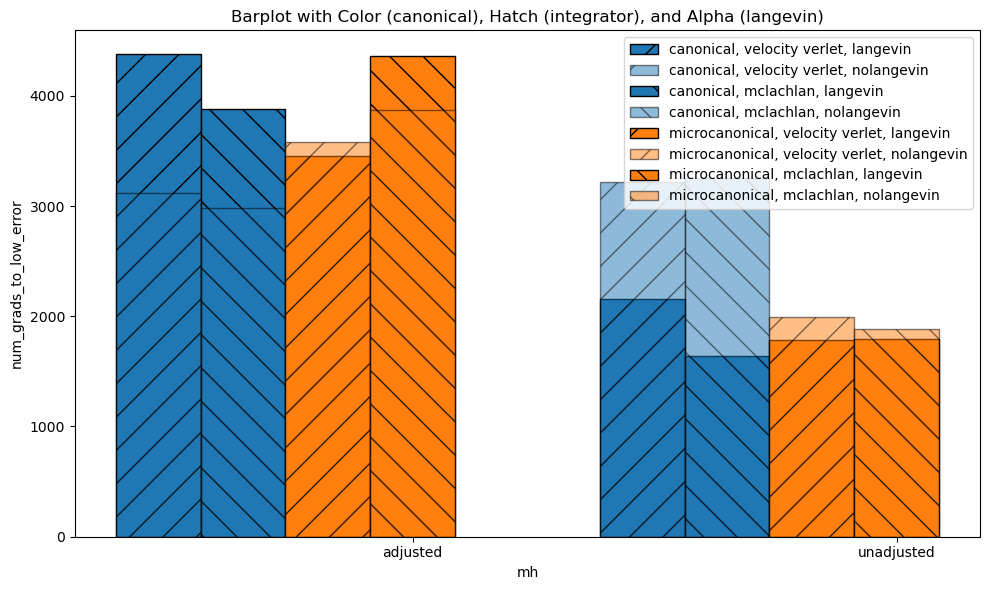

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,grads_to_low_error_std,ess_corr,max,statistic,num_tuning_grads,L,step_size,batch_size,mh,canonical,langevin,tuning,integrator_type,precond
21,3,adjusted_canonical_langevin_alba_velocity verl...,vector_german_credit_numeric_sparse_logistic_r...,7.913784e+03,6.416385,NaN,False,square,304512.117188,2.000000,0.047843,128.0,adjusted,canonical,langevin,alba,velocity verlet,precond:True
73,3,adjusted_canonical_langevin_alba_mclachlan_pre...,vector_german_credit_numeric_sparse_logistic_r...,9.120882e+03,7.153489,NaN,False,square,399594.546875,2.000000,0.081365,128.0,adjusted,canonical,langevin,alba,mclachlan,precond:True
125,3,adjusted_canonical_nolangevin_alba_velocity ve...,vector_german_credit_numeric_sparse_logistic_r...,6.829699e+03,7.482105,NaN,False,square,280667.601562,1.867250,0.052861,128.0,adjusted,canonical,nolangevin,alba,velocity verlet,precond:True
177,3,adjusted_canonical_nolangevin_alba_mclachlan_p...,vector_german_credit_numeric_sparse_logistic_r...,8.868013e+03,5.170145,NaN,False,square,395613.671875,1.934436,0.082155,128.0,adjusted,canonical,nolangevin,alba,mclachlan,precond:True
229,3,adjusted_microcanonical_langevin_alba_velocity...,vector_german_credit_numeric_sparse_logistic_r...,7.836342e+03,9.016651,NaN,False,square,348755.734375,13.988275,0.390963,128.0,adjusted,microcanonical,langevin,alba,velocity verlet,precond:True
281,3,adjusted_microcanonical_langevin_alba_mclachla...,vector_german_credit_numeric_sparse_logistic_r...,1.075330e+04,4.695477,NaN,False,square,474216.421875,14.105754,0.605754,128.0,adjusted,microcanonical,langevin,alba,mclachlan,precond:True
333,3,adjusted_microcanonical_nolangevin_alba_veloci...,vector_german_credit_numeric_sparse_logistic_r...,7.820870e+03,8.981509,NaN,False,square,345253.296875,14.279504,0.396166,128.0,adjusted,microcanonical,nolangevin,alba,velocity verlet,precond:True
385,3,adjusted_microcanonical_nolangevin_alba_mclach...,vector_german_credit_numeric_sparse_logistic_r...,1.031806e+04,6.949360,NaN,False,square,476365.312500,14.281351,0.603590,128.0,adjusted,microcanonical,nolangevin,alba,mclachlan,precond:True
437,3,unadjusted_canonical_langevin_alba_velocity ve...,vector_german_credit_numeric_sparse_logistic_r...,6.941000e+03,710.060622,NaN,False,square,41556.000000,0.813373,0.027308,128.0,unadjusted,canonical,langevin,alba,velocity verlet,precond:True
489,3,unadjusted_canonical_langevin_alba_mclachlan_p...,vector_german_credit_numeric_sparse_logistic_r...,inf,NaN,NaN,False,square,83112.000000,2.515429,0.093175,128.0,unadjusted,canonical,langevin,alba,mclachlan,precond:True


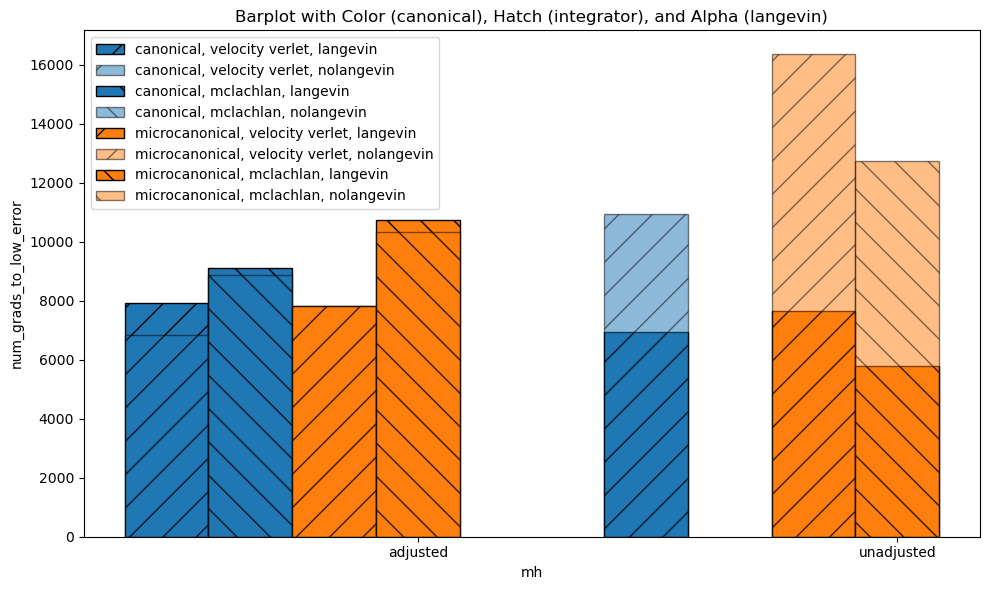

In [38]:

def plot_results():

    mh_options = [True, False]
    canonical_options = [True, False]
    langevin_options = [True, False]
    tuning_options = ['alba']
    integrator_type_options = ['velocity_verlet', 'mclachlan']
    diagonal_preconditioning_options = [True, False]
    models = [
        IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log'),
        IllConditionedGaussian(ndims=100, condition_number=1, eigenvalues='log'),
        brownian_motion(),
        german_credit(),
        ]

    redo = False 

    full_results = pd.DataFrame()
    for mh, canonical, langevin, tuning, integrator_type, diagonal_preconditioning, model in itertools.product(mh_options, canonical_options, langevin_options, tuning_options, integrator_type_options, diagonal_preconditioning_options, models):
        results = lookup_results(model=model, num_steps=20000, mh=mh, canonical=canonical, langevin=langevin, tuning=tuning, integrator_type=integrator_type, diagonal_preconditioning=diagonal_preconditioning, redo=redo, batch_size=512, relative_path='../../')
        full_results = pd.concat([full_results, results], ignore_index=True)

    full_results['mh'] = full_results['Sampler'].str.split('_').str[0]
    full_results['canonical'] = full_results['Sampler'].str.split('_').str[1]
    full_results['langevin'] = full_results['Sampler'].str.split('_').str[2]
    full_results['tuning'] = full_results['Sampler'].str.split('_').str[3]
    full_results['integrator_type'] = full_results['Sampler'].str.split('_').str[4]
    full_results['precond'] = full_results['Sampler'].str.split('_').str[5]
    full_results = full_results[full_results['max'] == False]
    full_results = full_results[full_results['precond'] == 'precond:True']

    


    # Filter results for velocity_verlet and mclachlan integrators
    # verlet_results = full_results[full_results['integrator_type'] == 'velocity_verlet']
    # mclachlan_results = full_results[full_results['integrator_type'] == 'mclachlan']
    # full_results["integrator_adjusted"] = full_results["integrator_type"] + '_' + full_results["mh"]


    # compare verlet and mclachlan results, for square, max: showing num_grads_to_low_error
    # Create figure with subplots
    # fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    # fig.suptitle('Comparison of Velocity Verlet vs Mclachlan Integrators', fontsize=16)

    # Plot num_grads_to_low_error for square, max
    for model in models:

        results_model = full_results[full_results['Model'] == model.name]
        cov_results = results_model[results_model['statistic'] == 'covariance']
        square_results = results_model[results_model['statistic'] == 'square']

        display(square_results)
        
        # hue should be product of canonical and langevin
        # full_results['canonical_langevin'] = full_results['canonical'].astype(str) + '_' + full_results['langevin'].astype(str)
        # without build in legend, add legend manually
        # sns.relplot(data=cov_results, x='mh', y='num_grads_to_low_error', hue='canonical', style='integrator_type', size='langevin', legend=True)
        # sns.relplot(data=square_results, x='mh', y='num_grads_to_low_error', hue='canonical', style='integrator_type', size='langevin', legend=True)
        # sns.barplot(data=square_results, x='mh', y='num_grads_to_low_error', hue='canonical', legend=True)

        

        # Example: replace this with your actual DataFrame
        # square_results = pd.DataFrame({
        #     'mh': ['A', 'A', 'B', 'B'],
        #     'canonical': ['yes', 'no', 'yes', 'no'],
        #     'integrator': ['euler', 'rk4', 'euler', 'rk4'],
        #     'num_grads_to_low_error': [10, 12, 8, 15]
        # })


        color_map = {'canonical': 'tab:blue', 'microcanonical': 'tab:orange'}  # adjust as needed
        hatch_map = {'velocity verlet': '/', 'mclachlan': '\\'}              # adjust as needed

        # Define color, hatch, and alpha maps
        alpha_map = {'langevin': 1.0, 'nolangevin': 0.5}

        df = square_results

        mh_order = df['mh'].unique()
        canonical_order = df['canonical'].unique()
        integrator_order = df['integrator_type'].unique()
        langevin_order = df['langevin'].unique()

        bar_width = 0.35
        n_hue = len(canonical_order)
        n_hatch = len(integrator_order)

        fig, ax = plt.subplots(figsize=(10, 6))

        for i, mh in enumerate(mh_order):
            for j, canonical in enumerate(canonical_order):
                for k, integrator in enumerate(integrator_order):
                    for l, langevin in enumerate(langevin_order):
                        row = df[
                            (df['mh'] == mh) &
                            (df['canonical'] == canonical) &
                            (df['integrator_type'] == integrator) &
                            (df['langevin'] == langevin)
                        ]
                        if not row.empty:
                            y = row['num_grads_to_low_error'].values[0]
                            x = i + (j - n_hue/2) * bar_width + (k - n_hatch/2) * (bar_width / n_hatch)
                            ax.bar(
                                x, y, width=bar_width / n_hatch,
                                color=color_map[canonical],
                                hatch=hatch_map[integrator],
                                edgecolor='black',
                                alpha=alpha_map[langevin],
                                label=f"{canonical}, {integrator}, {langevin}" if i == 0 else ""
                            )

        ax.set_xticks(np.arange(len(mh_order)))
        ax.set_xticklabels(mh_order)
        ax.set_xlabel('mh')
        ax.set_ylabel('num_grads_to_low_error')
        ax.set_title('Barplot with Color (canonical), Hatch (integrator), and Alpha (langevin)')

        # Build custom legend
        from matplotlib.patches import Patch
        legend_elements = []
        for canonical in canonical_order:
            for integrator in integrator_order:
                for langevin in langevin_order:
                    legend_elements.append(
                        Patch(
                            facecolor=color_map[canonical],
                            hatch=hatch_map[integrator],
                            edgecolor='black',
                            alpha=alpha_map[langevin],
                            label=f"{canonical}, {integrator}, {langevin}"
                        )
                    )


        # ax.legend(handles=legend_elements, title='canonical, integrator, langevin')
        ax.legend()

        plt.tight_layout()
        plt.show()




        # plt.legend(title='', fontsize=6)
        # for i,text in enumerate(plt.gca().get_legend().get_texts()):
        #     if i in [0, 3, 6]:
        #         text.set_fontweight('bold')
        # plt.title(model.name)
        # plt.show()

plot_results()

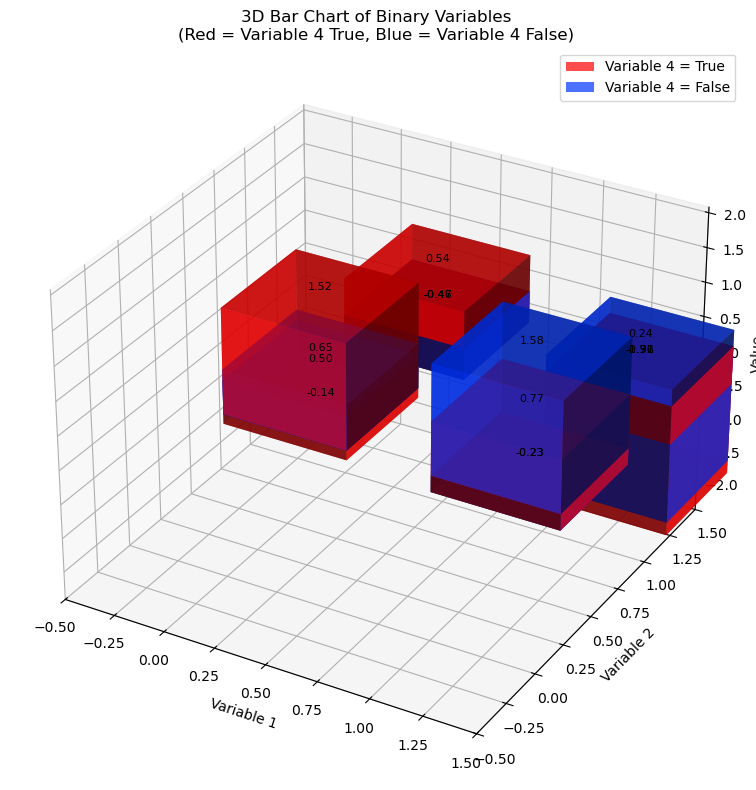

In [51]:
# display all rows
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_results)

In [11]:
TypeError: Axes3D.bar3d() got multiple values for argument 'color'


SyntaxError: invalid syntax (3354982332.py, line 1)